In this blog post, I will explore the use of a collaborative filtering algorithm on a real movie dataset.

### Problem Description:

As discussed in my last post, we can make a recommender system using a collaborative filtering algorithm. This exercise will use Amazon product review data obtained from [here](http://jmcauley.ucsd.edu/data/amazon/). Big thanks to Julian for giving me access to this data! Also, a lot of the inspiration and coding for this blog post came from an exercise done in my [data science program at UBC](http://masterdatascience.science.ubc.ca/)!

### Initialization:

First, we will need to load appropriate libraries and do a little light wrangling.

In [1]:
# Importing
import feather
import pandas as pd
import numpy as np
import mpld3 as mpld3
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [2]:
# Constants:
REDUCED_NUM_REVIEWERS = 1000
REDUCED_NUM_PRODUCTS = 1000
MIN_NUM_REVIEWS_MOVIE = 250
MIN_NUM_REVIEWS_PERSON = 10

In [3]:
# Reading data
df = feather.read_dataframe("../results/movie_df.feather")

The wrangling done below will only get movies that have reviewed a minimum amount of times. Additionally, only users that have rated a minimum amount of movies will be selected. This was mostly done because if I hadn't, I would often get a lot of obscure movie titles that I haven't heard of before. 

In [4]:
# Find number of reviewers per movie and 
# the number of movies reviewed by each person
n_reviews_movie_df = df.groupby('asin').reviewer_id.nunique()
n_reviews_person_df = df.groupby('reviewer_id').asin.nunique()

# Get list of movies that have been reviewed
# more than MIN_NUM_REVIEWS_MOVIE times and 
# users that have reviewed more than 
# MIN_NUM_REVIEWS_PERSON
popular_movies = list(n_reviews_movie_df[n_reviews_movie_df > MIN_NUM_REVIEWS_MOVIE].index)
critical_people = list(n_reviews_person_df[n_reviews_person_df > MIN_NUM_REVIEWS_PERSON].index)

# Filter dataframe to use only popular movies
# and critical people:
popular_df = df[df['asin'].isin(popular_movies)]
popular_df = popular_df[popular_df['reviewer_id'].isin(critical_people)]

# Peak at data:
popular_df[popular_df.reviewer_id == "A1006V961PBMKA"]

,reviewer_id,asin,overall,review_time,title,price
417286,A1006V961PBMKA,157330686X,5.0,1138838400,Beavis and Butt-head: The Final Judgement,1.99
1352554,A1006V961PBMKA,B00005JLEW,4.0,1055203200,Angel - Season One,12.17
1642271,A1006V961PBMKA,B0000797E5,5.0,1047254400,Coupling - The Complete First Season,11.93
1776003,A1006V961PBMKA,B0000CG89W,5.0,1068076800,Rush - Rush in Rio,27.58


Great! We now have a nice little dataframe. Beavis and Butt-head for 2 bucks. What a steal! Using the above dataframe, let's keep track of the first review to use as sanity checks:

In [5]:
# Get ID's to be used later as sanity checks (this is the Beavis and Butt-head review above)
person_of_interest = "A1006V961PBMKA"
product_of_interest = "157330686X"

Some additional wrangling and printing out basic statistics about the dataset:

In [6]:
# Only take relevant columns:
rating_df = popular_df[['reviewer_id', 'asin', 'overall']]

# Obtaining number of reviewers and products reviewed:
n_reviewers = len(rating_df.reviewer_id.unique())
n_products = len(rating_df.asin.unique())

# Print results:
print("There are", n_reviewers, "reviewers")
print("There are", n_products, "products reviewed")

There are 19118 reviewers
There are 1892 products reviewed


Great, we have reviewers and movies. FYI, the reason why I am saying "product" in my code is because I was previously using other amazon product data sets available [here](http://jmcauley.ucsd.edu/data/amazon/).

Next, we are working to construct a matrix where each row is a reviewer and each column is a movie. I initially construct it as a sparse array, which I think is the correct thing to do. Unfortunately, later I simply work with it as a normal dense array. If I were to repeat this exercise, I would have liked to continue to work with it as a sparse matrix. 

In [7]:
# Creating map to map from reviewer id/asin(product id) to a number and vice versa:
reviewerID_to_index_map = dict(zip(np.unique(rating_df.reviewer_id), list(range(n_reviewers))))
productID_to_index_map = dict(zip(np.unique(rating_df.asin), list(range(n_products))))
productID_to_title_map = dict(zip(popular_df.asin, popular_df.title))
index_to_productID_map = dict((reversed(item) for item in productID_to_index_map.items()))

# Creating dataframe with reviewer_id. This is done because we need to shuffle
# an array made below and need to keep track of how we shuffled it.
tracker_df = pd.DataFrame({ 'reviewer_id': np.unique(rating_df.reviewer_id)})

Now, we will make a sparse matrix where each row is a reviewer and each column is a product (movie in this case): 

In [8]:
# Obtain indicies associated with each id.
# This is used to create a sparse matrix later. 
reviewer_index = np.array([reviewerID_to_index_map[reviewer_id] for reviewer_id in rating_df.reviewer_id])
product_index = np.array([productID_to_index_map[asin] for asin in rating_df.asin])

# Obtain ratings to be put into sparse matrix:
ratings = np.array(rating_df.overall)

# Create sparse X matrix:
X = coo_matrix((ratings, (reviewer_index, product_index)), shape=(n_reviewers, n_products))

Great, the sparse matrix `X` has now been constructed. Let's just double check that we did everything right:

In [9]:
# Performing sanity check:
person_of_interest_index = reviewerID_to_index_map[person_of_interest]
product_of_interest_index = productID_to_index_map[product_of_interest]

X.toarray()[person_of_interest_index, product_of_interest_index]

5.0

Great, this result makes sense.

Now, the rating data is in a sparse matrix where the rows are users and the columns are movies. Note that all values of 0 for ratings are actually missing reviews. Reviewers cannot give something 0 stars. This is because `coo_matrix` by default fills in missing values with 0.

### Making our first model:

Now, let's use gradient descent to make our first model.

The code below uses gradient descent to learn the correct values for `U` and `V`. `U` can be thought as an array where each row is associated with a specific person and each column represents some sort of learned preference of theirs. These learned preferences are the number of latent features. `V` can be thought of as an array where each column is associated with a specific movie and the rows are the learned quality of the movie. This learned quality of the movie corresponds to the learned preference of the movie. 

For example, let's first assume that one of "learned preference" happend to be a preference towards scary movies. The "learned quality" of the movie would be how scary the movie was. This is further explained in my last blog post. 

As an additional note, I am performing gradient descent a little differently than I had in my previous blog post. Essentially, these are both the same.

In [10]:
# Using dense array for now:
X_array_all = X.toarray()

# Reduce size of dataset (REMOVE LATER):
# The main issue occurs below during gradient descent.
# np.dot() takes a long time. This is discussed further below:
X_array = X_array_all[0:REDUCED_NUM_REVIEWERS, 0:REDUCED_NUM_PRODUCTS]

In [11]:
# Set up parameters:
n_iters = 2000
alpha = 0.0005
num_latent_features = 2

# Randomly initialize:
U = np.random.randn(REDUCED_NUM_REVIEWERS, num_latent_features) * 1e-5
V = np.random.randn(num_latent_features, REDUCED_NUM_PRODUCTS) * 1e-5

# Perform gradient descent:
for i in range(n_iters):
    
    # Obtain predictions:
    X_hat = np.dot(U, V)     
    
    # Make sure the person of interest didn't blow up:
    if np.isnan(X_hat[person_of_interest_index, product_of_interest_index]):
        print("ERROR")
        break
        
    # Obtain residual
    resid = X_hat - X_array
    resid[np.isnan(resid)] = 0
    
    # Calculate gradients:
    dU = np.dot(resid, V.T) 
    dV = np.dot(U.T, resid)
    
    # Update values:
    U = U - dU*alpha
    V = V - dV*alpha
    
    # Output every 10% to make sure on the right track:
    if (i%(n_iters/10) == 0):
        print("Iteration:", i, 
              "   Cost:", np.sum(resid**2), 
              "   Rating of interest:", X_hat[person_of_interest_index, product_of_interest_index])
    
X_pred = np.dot(U, V)

predicted_val = X_pred[person_of_interest_index, product_of_interest_index]
actual_val = X_array[person_of_interest_index, product_of_interest_index]
print("Actual Rating: ", actual_val)
print("Predicted Rating: ", predicted_val)   

Iteration: 0    Cost: 149328.0    Rating of interest: 9.23417476899e-11
Iteration: 200    Cost: 147354.447868    Rating of interest: 3.54427442441e-07
Iteration: 400    Cost: 134065.676434    Rating of interest: 8.83359655088e-06
Iteration: 600    Cost: 130777.229726    Rating of interest: 0.000284148315826
Iteration: 800    Cost: 130714.832445    Rating of interest: 0.000285267304572
Iteration: 1000    Cost: 130682.686159    Rating of interest: 0.000280843494529
Iteration: 1200    Cost: 130666.029816    Rating of interest: 0.000272693862433
Iteration: 1400    Cost: 130657.518261    Rating of interest: 0.000264440745729
Iteration: 1600    Cost: 130653.214577    Rating of interest: 0.000257557463015
Iteration: 1800    Cost: 130651.051701    Rating of interest: 0.000252272874565
Actual Rating:  5.0
Predicted Rating:  0.000248372222236


The above prediction is awful. This is because we didn't handle `nan` properly. The algorithm above is trying to account for all the zero values. The "signal" is being drowned out. To fix this is simple:

### Making our second model:

In [12]:
# Replacing zeros with nan:
# (THIS IS THE FIX)
X_array[X_array==0] = np.nan

# Set up parameters:
n_iters = 2000
alpha = 0.0005
num_latent_features = 2

# Initialize U and V randomly
U = np.random.randn(REDUCED_NUM_REVIEWERS, num_latent_features) * 1e-5
V = np.random.randn(num_latent_features, REDUCED_NUM_PRODUCTS) * 1e-5

# Perform gradient descent:
for i in range(n_iters):        
    # Obtain predictions:
    X_hat = np.dot(U, V)     
    
    if np.isnan(X_hat[person_of_interest_index, product_of_interest_index]):
        print("ERROR")
        break
        
    # Obtain residual
    resid = X_hat - X_array
    resid[np.isnan(resid)] = 0
    
    # Calculate gradients:
    dU = np.dot(resid, V.T) 
    dV = np.dot(U.T, resid)
    
    # Update values:
    U = U - dU*alpha
    V = V - dV*alpha
    
    # Output every 10% to make sure on the right track:
    if (i%(n_iters/10) == 0):
        print("Iteration:", i, 
              "   Cost:", np.sum(resid**2), 
              "   Rating of interest:", X_hat[person_of_interest_index, product_of_interest_index])
    
# Make prediction:
X_pred = np.dot(U, V)

predicted_val = X_pred[person_of_interest_index, product_of_interest_index]
actual_val = X_array[person_of_interest_index, product_of_interest_index]
print("Actual Rating: ", actual_val)
print("Predicted Rating: ", predicted_val)

Iteration: 0    Cost: 149328.0    Rating of interest: -5.59277229197e-11
Iteration: 200    Cost: 148438.450057    Rating of interest: 1.64644014735e-07
Iteration: 400    Cost: 21162.4629708    Rating of interest: 0.0277345247496
Iteration: 600    Cost: 6469.82785038    Rating of interest: 0.209813998352
Iteration: 800    Cost: 4547.7766815    Rating of interest: 0.652343621542
Iteration: 1000    Cost: 4027.94633082    Rating of interest: 1.41466589158
Iteration: 1200    Cost: 3821.79941346    Rating of interest: 2.35071616693
Iteration: 1400    Cost: 3712.27199438    Rating of interest: 3.16304209196
Iteration: 1600    Cost: 3592.10366719    Rating of interest: 3.75952551378
Iteration: 1800    Cost: 3465.80626753    Rating of interest: 4.2744406126
Actual Rating:  5.0
Predicted Rating:  4.63160978837


This is a huge improvement! Awesome! Next, I will try to scale this up to use the entire dataset:

### Making our third model:

One way we can use our entire dataset is to use **mini batch gradient descent**. The reason why gradient descent performed slowly above is because for each iteration, we use **all of the data** at once. With mini batch gradient descent, we will only use some of the data (a subset of reviewers in this case) in each iteration. This is implemented below:

In [13]:
# Replacing zeros with nan:
X_array_all[X_array_all==0] = np.nan

# Randomly initialize:
num_latent_features = 2
U = np.random.randn(n_reviewers, num_latent_features) * 1e-5
V = np.random.randn(num_latent_features, n_products) * 1e-5
k = 1

# Initialize X_hat:
X_hat = U@V

batch_size = 200
n_iters = 2000

alpha = 0.0005

# Perform gradient descent:
for i in range(n_iters):
    
    # Shuffle users:
    (X_array_all, U, tracker_df) = shuffle(X_array_all, U, tracker_df)
    person_of_interest_index = np.where(tracker_df.reviewer_id == person_of_interest)[0][0]
    
    for j in range(0, n_reviewers, batch_size):
        # Make sure doesn't pass array size
        if j + batch_size > n_reviewers:
            break

        # Select mini batches of data:
        mini_X_array = X_array_all[j:j+batch_size, :]
        mini_U = U[j:j+batch_size, :]

        # Calculate predicted values
        mini_X_hat = mini_U@V

        # Calculate error
        resid = mini_X_hat - mini_X_array
        resid[np.isnan(resid)] = 0 

        mini_dU = np.dot(resid, V.T)
        dV = np.dot(mini_U.T, resid)

        U[j:j+batch_size] = U[j:j+batch_size] - mini_dU*alpha
        V = V - dV*alpha
        
    if (i%(n_iters/10) == 0) or (i >= (n_iters-1)):
        print( "Iteration:", i,  
               "   Batch Cost:", np.sum(resid**2),
               "   Person of Interest:", np.dot(U[person_of_interest_index,:], V[:, product_of_interest_index]))

    
X_pred = U@V
predicted_val = X_pred[person_of_interest_index, product_of_interest_index]
actual_val = X_array_all[person_of_interest_index, product_of_interest_index]

print("Actual Rating: ", actual_val)
print("Predicted Rating: ", predicted_val)   

Iteration: 0    Batch Cost: 51756.0    Person of Interest: 5.42523706054e-11
Iteration: 200    Batch Cost: 3726.08751571    Person of Interest: 3.22180234032
Iteration: 400    Batch Cost: 2265.31886671    Person of Interest: 3.66713496753
Iteration: 600    Batch Cost: 2209.48755233    Person of Interest: 3.78127567013
Iteration: 800    Batch Cost: 1814.55120794    Person of Interest: 3.96004152284
Iteration: 1000    Batch Cost: 1266.66523156    Person of Interest: 4.30239322962
Iteration: 1200    Batch Cost: 1697.20689401    Person of Interest: 4.64988082183
Iteration: 1400    Batch Cost: 1961.96275549    Person of Interest: 4.81763598273
Iteration: 1600    Batch Cost: 2247.37288285    Person of Interest: 4.8528168213
Iteration: 1800    Batch Cost: 2037.44505783    Person of Interest: 4.82827576696
Iteration: 1999    Batch Cost: 1546.36963879    Person of Interest: 4.79086267523
Actual Rating:  5.0
Predicted Rating:  4.79086267523


Great, now that we've used all of our data, let's check our results. I feel like the way I am about to do this is clunky, but it gets the job done:

In [14]:
# Initializing parameters:
n_reviews = rating_df.shape[0]
prediction_list = list()
title_list = list()

# Matching ratings with proper reviewer and product:
for i in range(n_reviews):
    rev_id = rating_df.iloc[i].reviewer_id
    prod_id = rating_df.iloc[i].asin

    rev_index = reviewerID_to_index_map[rev_id]
    prod_index = productID_to_index_map[prod_id]
    
    prediction = X_pred[rev_index, prod_index]
    title = productID_to_title_map[prod_id]
    
    title_list.append(title)
    prediction_list.append(prediction)
    
# Making dataframe:
result_df = pd.DataFrame({"reviewer_id": rating_df.reviewer_id,
                          "product_name": title_list,
                          "actual_rating": rating_df.overall,
                          "predicted_rating": prediction_list
                         })

# Peaking at results:
shuffle(result_df, random_state=4242).head(10)

,actual_rating,predicted_rating,product_name,reviewer_id
2295644,2.0,0.518928,Doom (Unrated Widescreen Edition),A2UN5UY8Q6YMOF
1440037,5.0,2.855683,"Good Night, and Good Luck.",A3VIOCJZ22JZXT
147096,5.0,5.203756,Galaxy Quest [VHS],A2KB65SOJ51T4C
239959,5.0,5.466800,Casablanca [VHS],A2Q07KQAAFWVL7
1451765,5.0,4.497967,The Queen,A2LRXG7OSIYS7C
1370499,3.0,3.557857,The Matrix Reloaded [VHS],A1IEKFEQFKZU2J
508800,4.0,2.068891,Star Trek - The Motion Picture [VHS],A2BT578J4IZOK6
2219770,5.0,3.341353,Cinderella Man (Widescreen Edition),A2GPEV42IO41CI
227363,4.0,4.630181,The Searchers [VHS],AHT5JOGQWGOCS
1425466,5.0,4.443942,Cars (Single-Disc Widescreen Edition),A1EMDSTJDUE6B0


These results aren't too horrible. I think with more iterations, this would improve further. Although, during my last few iterations, the "batch cost" did not seem to be going down consistently.

### Analysis:

One idea that can be done as a result from our model is we can group movies together. We have obtained these "learned features", why not use them? So now, I will try to make a plot to visualize the learned features:

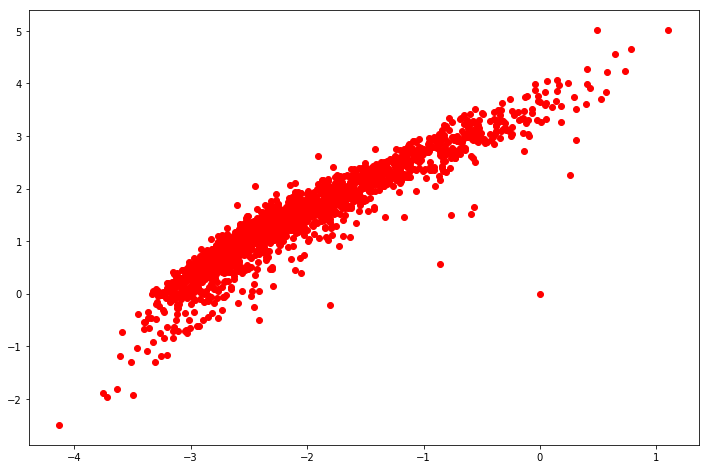

In [15]:
# Getting the two latent features of each movie
param1 = V.T[:,0]
param2 = V.T[:,1]

# Matching latent features to appropriate movie:
movie_title_list = list()
for index, productID in index_to_productID_map.items():
    movie_title_list.append(productID_to_title_map[productID])
    
# Plotting the products:
plt.figure(figsize=(12,8))
plt.plot(param1, param2, 'ro')
plt.show()

Interesting, when using 2 latent-features, this is how the movies were distributed. Let's try to use k-means clustering:

In [16]:
# Performing k-means:
kmeans = KMeans(n_clusters=10, random_state=0).fit(V.T)
groups = kmeans.labels_

In [17]:
# Making plot:
fig = plt.figure(figsize=(12,8))

scatter = plt.scatter(param1, param2, c=groups)

tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=movie_title_list)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

Try hovering over these points, the movie title should display!

### Closing Notes:

Unfortunately, these groups don't seem to make immediate sense. Honestly, the trends within groups that seem to be present are probably by luck. It would be nice to see groups of movies that had an obvious theme going on such as genre or time when released. Perhaps in the future, we can make better groups if we use more latent features (we used 2 in this case). 

In future blog posts I plan to:
* Scale up to use more data and use regularization
* Create a twitter bot that may be able to identify which movies are trending on social media
    * This can be used to promote movies that are trending to people that we predicted would give it a high rating. 
    * The same idea can be applied to Amazon's "Toys and Games" data set. My thought that it would be able to promote something like a fidget spinner to people which seems to be all the rage now a days. 
* Create better models be adding more features to our dataset. This can easily be done by altering our mini batch gradient descent loop. 
* We may be able to find more interesting patterns if we account for bias by subtracting from each rating by each person's average rating as well as the average rating for each movie

Please let me know if you have any other cool ideas/questions/suggestions/**found mistakes**! My e-mail is andrewlim90@gmail.com